# **MNIST 숫자 인식**

---


- 💡 **NOTE**
    - 이 노트북의 코드를 실행하려면 GPU를 사용하는 것이 좋습니다. 구글 코랩에서는 **런타임 > 런타임 유형 변경 > 하드웨어 가속기 > T4 GPU**를 선택하세요.


---

## [**예제] : MNIST 손글씨 숫자(0~9) 분류 문제**
- 이미지 크기 : 28 x 28

### **1) 전통적 알고리즘 방식 (Rule-based)**
- 설명: 사람이 직접 픽셀 값이나 형태의 규칙을 정의하여 분류
- 단점: 너무 복잡하고 일반화 불가능
- 예제: 이미지를 흑백으로 바꾸고 픽셀 비율로 ‘0’과 ‘1’을 구분

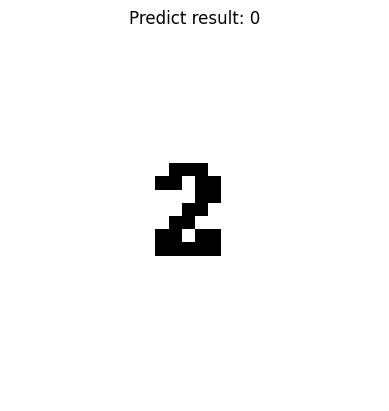

✅ [전통적 알고리즘 방식] 예측 결과: 0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def predict_digit_012(image_array):
    """
    28x28 이미지에서 0, 1, 2 중 하나를 단순한 시각적 특징 기반으로 예측 (예측이 잘 안됨)
    """
    white_ratio = np.mean(image_array > 200)   # 전체 픽셀 대비 흰색(255) 비율 계산
    vertical_blackness = np.sum(image_array[:, 13:15] < 100)  # 중앙 세로선 부근
    lower_half_blackness = np.sum(image_array[14:, :] < 100)

    # 규칙 기반 예측
    if white_ratio > 0.8:
        return 0  # 대부분 흰색 → '0'
    elif vertical_blackness > 50 and lower_half_blackness < 40:
        return 1  # 가운데 세로선 진하고, 하단은 비어있음 → '1'
    else:
        return 2  # 나머지 → '2'

def load_and_predict_012(filename):
    img = Image.open(filename).convert('L').resize((28, 28))
    img_array = np.array(img)

    prediction = predict_digit_012(img_array)

    # 시각화
    plt.imshow(img_array, cmap='gray')
    plt.title(f"Predict result: {prediction}")
    plt.axis('off')
    plt.show()

    return prediction

# 예측 실행
filename = 'digit_sample2.png'
# filename = 'digit_sample2.png'
result = load_and_predict_012(filename)
print("✅ [전통적 알고리즘 방식] 예측 결과:", result)


### **2) 기계학습 방식 (Machine Learning)**
- K-최근접 이웃, K-NN, K-NearestNeighbors
    - 설명: 이미지 데이터를 벡터화하고, 거리 기반 분류 수행
    - 라이브러리: scikit-learn, sklearn.neighbors.KNeighborsClassifier

- **1.모델 만들기** : 학습 데이터 준비 --> 학습(훈련) --> 모델 평가

In [7]:
# [방법1] : KNN 직접 구현
import numpy as np
from collections import Counter
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


# Euclidean 거리 계산 함수
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

# 정확도 계산
def custom_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


# KNN 클래스 구현
class CustomKNN:
    def __init__(self, n_neighbors=3):
        self.k = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        return np.array([self._predict(x) for x in X_test])

    def _predict(self, x):
        # 훈련 샘플과의 거리 계산
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # 거리 기준으로 k개 인덱스 추출
        k_indices = np.argsort(distances)[:self.k]
        # k개의 레이블 투표
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # 가장 흔한 레이블 반환
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

# 데이터 로드
digits = load_digits()
X, y = digits.data, digits.target  # (1797, 64)

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 생성 및 훈련
knn = CustomKNN(n_neighbors=3)
knn.fit(X_train, y_train)

# 예측
y_pred = knn.predict(X_test)

# 정확도 출력
print("✅ Custom KNN 정확도 (8x8 입력):", custom_accuracy(y_test, y_pred))


✅ Custom KNN 정확도 (8x8 입력): 0.9888888888888889


In [8]:
# [방법2] : Scikit-learn KNN 알고리즘 이용
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from skimage.transform import resize
import numpy as np

# 1. 8x8 숫자 이미지 로딩
digits = load_digits()
X, y = digits.data, digits.target  # X: (1797, 64)

# 2. 8x8 이미지를 28x28로 리사이즈
X_8x8 = X.reshape(-1, 8, 8)  # (1797, 8, 8)
X_28x28 = np.array([resize(img, (28, 28), anti_aliasing=True) for img in X_8x8])  # (1797, 28, 28)
X_flattened = X_28x28.reshape(-1, 28 * 28)  # (1797, 784)

# 3. 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# 4. KNN 분류기 훈련
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# 5. 예측 및 평가
y_pred = knn.predict(X_test)
print("✅ KNN 정확도 (28x28 입력):", accuracy_score(y_test, y_pred))


✅ KNN 정확도 (28x28 입력): 0.987037037037037


- **[참고]** : 숫자 이미지 그래프로 보여주기


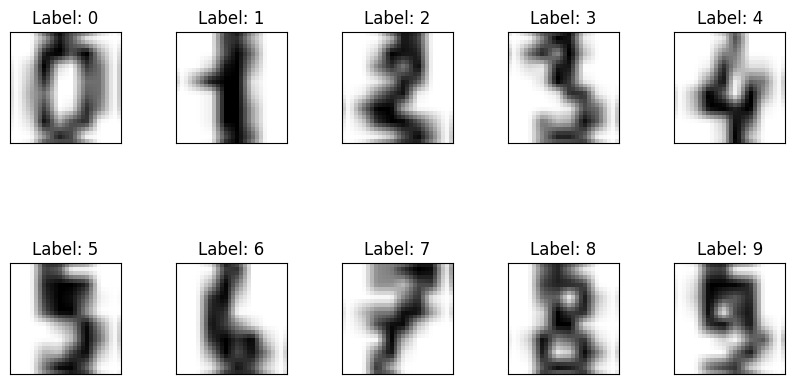

In [9]:
# [참고] 숫자 이미지를 그래프로 보여주는 함수 추가
import matplotlib.pyplot as plt

def plot_digits(X, Y):
    """
    load_digits() 데이터셋의 처음 10개 이미지를 시각화
    """
    fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.5, wspace=0.5))
    for i, ax in enumerate(axes.flat):
        # 8x8 이미지 표시
        image = X[i]
        label = Y[i]
        ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest')
        # 이미지의 실제 숫자 라벨을 제목으로 설정
        ax.set_title(f"Label: {label}")
    plt.show()


# 로드한 숫자 이미지를 그래프로 확인
plot_digits(X_28x28, y)


- **2.모델 예측** : 훈련된 모델로 테스트 데이터 예측

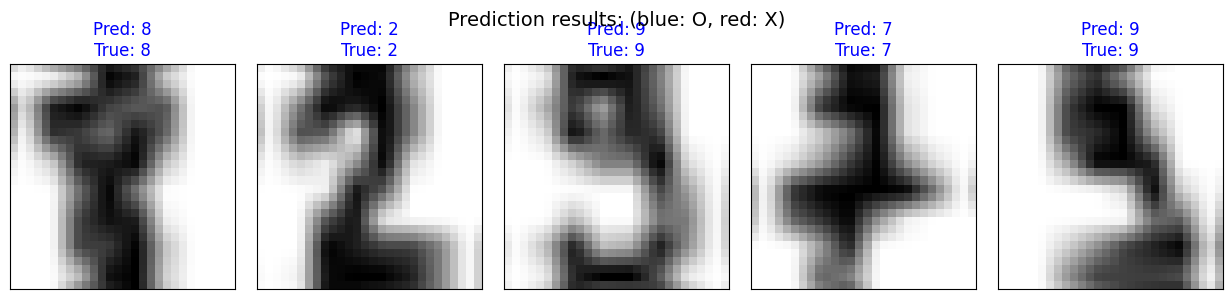

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def predict_mnist(X, y, model, num_samples=5):
    """
    입력 이미지 X와 레이블 y를 사용하여 학습된 모델의 예측 결과 시각화
    - X: 테스트 이미지 배열 (flatten된 형태, 예: (n_samples, 64) 또는 (n_samples, 784))
    - y: 정답 레이블 (n_samples,)
    - model: 학습된 KNN 또는 분류 모델
    - num_samples: 무작위로 표시할 샘플 수
    """
    # 무작위 샘플 인덱스 선택
    random_indices = np.random.choice(len(X), size=num_samples, replace=False)

    # subplot 생성
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2.5, 3),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, idx in enumerate(random_indices):
        test_image = X[idx]
        true_label = y[idx]

        # 예측
        predicted_label = model.predict(test_image.reshape(1, -1))[0]

        # 이미지 해상도 자동 감지: 64→8x8, 784→28x28
        size = int(np.sqrt(test_image.shape[0]))
        image = test_image.reshape(size, size)

        # 시각화
        ax = axes[i]
        ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest')
        ax.set_title(f"Pred: {predicted_label}\nTrue: {true_label}",
                     color='blue' if predicted_label == true_label else 'red')

    plt.suptitle("Prediction results: (blue: O, red: X)", fontsize=14)
    plt.tight_layout()
    plt.show()

# 테스트 데이터를 이용하여 예측하기
predict_mnist(X_test, y_test, knn)

 - **[참고]** 이미지 파일 읽어서 예측

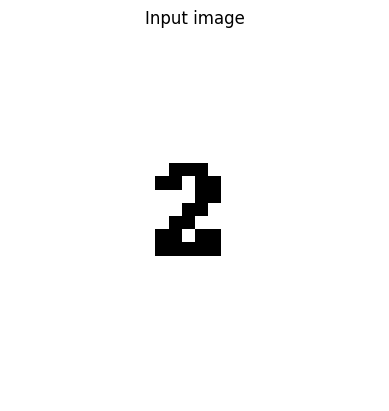

✅ Predict result : 0


In [11]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

def predict_image_with_model(model, filename):
    """
    모델 유형(KNN 또는 PyTorch CNN)에 따라 이미지 파일을 읽고 예측 결과 출력
    - model: 학습이 완료된 scikit-learn KNN 모델 또는 PyTorch CNN 모델
    - filename: 이미지 파일 경로 (28x28 크기라고 가정)
    """
    # 이미지 로드 및 전처리
    img = Image.open(filename).convert('L').resize((28, 28))
    img_array = np.array(img).astype(np.float32) / 255.0

    # 시각화
    plt.imshow(img_array, cmap='gray')
    plt.title("Input image")
    plt.axis('off')
    plt.show()

    # 모델 유형 판단 및 예측
    if isinstance(model, torch.nn.Module):
        # PyTorch 모델 예측
        model.eval()
        img_tensor = torch.tensor(img_array).unsqueeze(0).unsqueeze(0)  # (1, 1, 28, 28)
        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)
            return pred.item()

    else:
        # scikit-learn KNN 모델 예측
        img_flatten = img_array.reshape(1, -1)  # (1, 784)
        return model.predict(img_flatten)[0]


# 이미지 파일 읽어서 예측 실행
filename = 'digit_sample2.png'   # digit_sample0.png
result = predict_image_with_model(knn, filename)
print("✅ Predict result :", result )

### **3) 딥러닝 방식 (CNN 기반 모델)**
- 설명: 합성곱 신경망을 이용해 이미지의 특징을 자동 추출하고 학습
- 라이브러리: torch, torchvision

- **1.모델 만들기** : 학습 데이터 준비 --> 학습(훈련) --> 모델 평가

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# MNIST 데이터셋 로딩 (28 x 28)
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.fc = nn.Linear(32 * 14 * 14, 10)  # 28 x 28 -->MaxPool으로 반으로 줄어둔다.

    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

cnn_model = CNN()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


# 학습(훈련)
num_epochs = 1  # 1--> 5 --> 10으로 늘려본다.(늘릴 수록 시간이 오래 걸린다.)
epoch_losses = []  # 에폭별 손실 저장 리스트
running_loss = 0.0  # 에폭 동안의 누적 손실 초기화
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(images)         # 모델 예측
        loss = criterion(outputs, labels)   # 손실 계산
        loss.backward()                     # 역전파 수행 (자동 미분)
        optimizer.step()                    # 가중치 업데이트

        # 현재 배치의 손실 합산(손실 누적)
        running_loss += loss.item()

    # 에폭 종료 후 평균 손실 계산 및 저장
    epoch_loss = running_loss / len(train_loader)   # 평균 손실
    epoch_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# 평가
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # print(images.shape)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"✅ 딥러닝(CNN) 정확도: {100 * correct / total:.2f}%")


Epoch [1/1], Loss: 0.2284
✅ 딥러닝(CNN) 정확도: 97.28%


- **[참고]** : 사이킷런 숫자 이미지를 Pytorch 텐서로 변경하여 그래프로 보여주기

이미지 shape: torch.Size([10, 1, 28, 28])
라벨: tensor([6, 9, 3, 7, 2, 1, 5, 2, 5, 2])


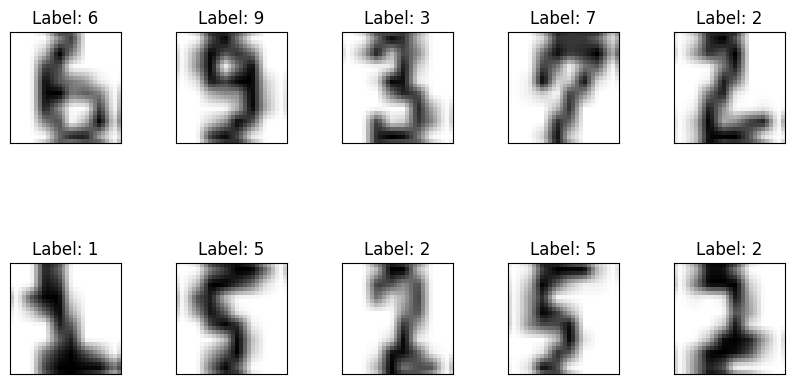

In [13]:
# 사이킷런 MNIST 이미지 예측하기
from sklearn.datasets import load_digits
import torch
import numpy as np
import matplotlib.pyplot as plt

# 사이킷런 MNIST 이미지를 파이토치용으로 변환
def load_digits_for_torch(X, Y, n_samples=10):
    """
    Scikit-learn 이미지를 PyTorch에서 사용 가능하도록 변환
    - 28x28 이미지 -> (N, 1, 28, 28) 형태의 텐서로 변환
    - 사이킷런은 1차원의 Flat한 데이트가 모델에서 사용됨
    - 픽셀 값은 0~1 범위로 정규화    """

    # (8x8)64차원 벡터 → 28x28 이미지로 reshape → (N, 28, 28)
    X_images = X.reshape(-1, 28, 28).astype(np.float32)

    # 0~16 범위 → 0~1 정규화
    X_images /= 56.0

    # PyTorch CNN 입력 형태: (N, 1, 28, 28)
    X_tensor = torch.tensor(X_images).unsqueeze(1)  # 채널 차원 추가
    y_tensor = torch.tensor(Y, dtype=torch.long)

    return X_tensor[:n_samples], y_tensor[:n_samples]


def plot_digits_for_torch(X_torch, y_torch):
    """
    load_digits_for_torch() 데이터셋의 처음 10개 이미지를 시각화
    """
    fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.5, wspace=0.5))
    for i, ax in enumerate(axes.flat):
        # 8x8 이미지 표시
        img = X_torch[i].squeeze().numpy()
        label = y_torch[i].item()
        ax.imshow(img, cmap=plt.cm.binary, interpolation='nearest')
        # 이미지의 실제 숫자 라벨을 제목으로 설정
        ax.set_title(f"Label: {label}")

    plt.show()


# 앞에서 읽어온 사이킷런 MNIST 데이터를 --> 파이토치용으로 변환
X_torch, y_torch = load_digits_for_torch(X_test, y_test)
print("이미지 shape:", X_torch.shape)  # torch.Size([10, 1, 28, 28])
print("라벨:", y_torch)

# 로드한 숫자 이미지를 그래프로 확인
plot_digits_for_torch(X_torch, y_torch)


- **2.모델 예측** : 훈련된 모델로 테스트 데이터 예측

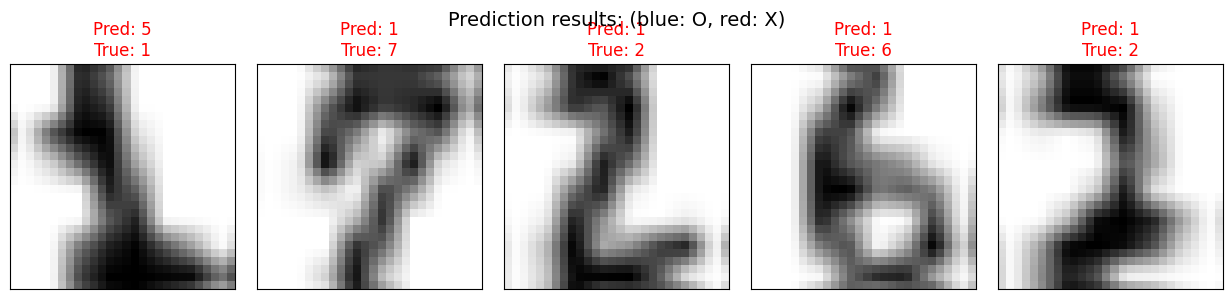

In [15]:

def predict_mnist_pytorch(X, y, model, num_samples=5, device='cpu'):
    """
    PyTorch 형식의 MNIST 데이터를 사용하여 모델 예측 시각화
    - X: 테스트 이미지 Tensor (N, 1, 28, 28) 또는 (N, 28, 28)
    - y: 정답 레이블 Tensor (N,)
    - model: 학습된 PyTorch 분류 모델
    - num_samples: 무작위로 시각화할 샘플 수
    - device: 모델이 있는 장치 (예: 'cpu' 또는 'cuda')
    """
    model.eval()
    model.to(device)

    if isinstance(X, torch.utils.data.Dataset):
        raise ValueError("X는 텐서여야 합니다. Dataset이 아니라 tensor(batch) 단위로 넘겨주세요.")

    if len(X.shape) == 3:  # (N, 28, 28) → (N, 1, 28, 28)
        X = X.unsqueeze(1)

    X = X.to(device)
    y = y.to(device)

    indices = np.random.choice(len(X), size=num_samples, replace=False)
    images = X[indices]
    labels = y[indices]

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    # 시각화
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2.5, 3),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i in range(num_samples):
        image = images[i].cpu().squeeze().numpy()  # (1,28,28) → (28,28)
        true_label = labels[i].item()
        predicted_label = preds[i].item()

        ax = axes[i]
        ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest')
        ax.set_title(f"Pred: {predicted_label}\nTrue: {true_label}",
                     color='blue' if predicted_label == true_label else 'red')

    plt.suptitle("Prediction results: (blue: O, red: X)", fontsize=14)
    plt.tight_layout()
    plt.show()


# 모델을 학습한 후 다음처럼 호출
predict_mnist_pytorch(X_torch, y_torch, model=cnn_model, num_samples=5, device='cuda')
